In [14]:
from obspy import read
from obspy.core import UTCDateTime
import numpy as np
import matplotlib.pyplot as plt
import math as M
from matplotlib import mlab
from matplotlib.colors import Normalize
import requests
from lxml import html

%matplotlib inline
#data_url = 'https://rawdata.oceanobservatories.org/files/RS01SLBS/LJ01A/09-HYDBBA102/2017/10/06/OO-HYVM1--YDH-2017-10-06T20:00:00.000015.mseed'
#localFileName = '../data/merged_hydrophone.mseed'

In [15]:
# web craweler
array = '/RS03AXBS' # Axial Base
node = '/LJ03A'
instrument = '/09-HYDBBA302'
year = '/2015'
month = '/09'
day = '/06/'
mainurl = 'https://rawdata.oceanobservatories.org/files'+array+node+instrument+year+month+day
mainurlpage =requests.get(mainurl)
webpage = html.fromstring(mainurlpage.content)
suburl = webpage.xpath('//a/@href')

FileNum = len(suburl) 
timestep = 5 #save results every 5 seceonds (no overlap)

data_url_list = []
for filename in suburl[6:FileNum]:
    data_url_list.append(str(mainurl + filename[2:]))

# Read Data from URL

In [16]:
RMS = []
time_RMS = []
samp_rate = 64000
delta_t = 5*60
num_samp = int(delta_t*samp_rate)

filenum = 4
stream = read(data_url_list[0])
for data_url in data_url_list[1:filenum]:
    #print(filenum)
    streamA = read(data_url)         # Read from url
    stream = stream + streamA

In [17]:
stream.merge()
print(stream)

1 Trace(s) in Stream:
OO.AXVM1..YDH | 2015-09-06T00:00:00.000000Z - 2015-09-06T00:10:00.000000Z | 64000.0 Hz, 38400001 samples (masked)


In [18]:
stream.plot

<bound method Stream.plot of <obspy.core.stream.Stream object at 0x7fb5e67785c0>>

# Slice Data 

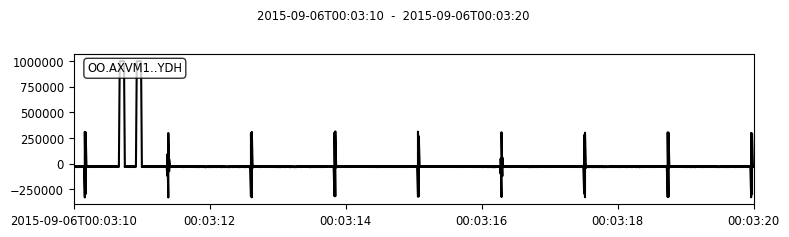

In [51]:
t_start = stream[0].stats.starttime + 190
t_end = stream[0].stats.starttime + 200
st = stream.slice(t_start, t_end)
trace = st[0].copy()
trace.plot()

In [26]:
stream[0].stats

         network: OO
         station: AXVM1
        location: 
         channel: YDH
       starttime: 2015-09-06T00:00:00.000000Z
         endtime: 2015-09-06T00:10:00.000000Z
   sampling_rate: 64000.0
           delta: 1.5625e-05
            npts: 38400001
           calib: 1.0
         _format: MSEED
           mseed: AttribDict({'dataquality': 'D', 'number_of_records': 5712, 'encoding': 'STEIM2', 'byteorder': '>', 'record_length': 4096, 'filesize': 23396352})

In [29]:
Fs = stream[0].stats.sampling_rate
L = stream[0].stats.npts
print(L/Fs)

600.000015625


# SPL Calculation

In [30]:
duration = stream[0].stats.endtime-stream[0].stats.starttime
print(duration/60)

10.0


In [80]:
t_end = stream[0].stats.starttime

SPL = []
t_spl = []
#st2 = np.zeros(320001)
for i in range(0,5,1):
    t_start = t_end 
    t_end = t_start + 60
    st = stream.slice(t_start, t_end)
    st2 = np.square(st[0])
    st2 = st2[np.where(~np.isnan(st2))]
    p_rms = np.sqrt(np.mean(st2))
    spl = 20*np.log10(p_rms)
    print(spl)
    SPL.append(spl)
    t_spl.append(t_start)

89.26704270033991
89.26655678498201
89.25805129479612


/opt/conda/lib/python3.6/site-packages/ipykernel/__main__.py:10: UserWarning: Warning: converting a masked element to nan.


89.76743706747568
89.76350517834958


In [34]:
print(SPL)

[89.26679970454636, nan, nan, 89.26288999568595, 89.26522844052279]


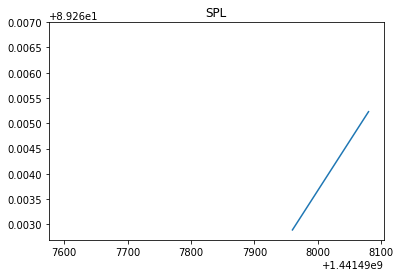

In [33]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(t_spl,SPL)
#ax.xaxis_date()
#fig.autofmt_xdate()
plt.title('SPL')
#plt.ylim(208, 212)
plt.show()

# Ping Detector

In [7]:
pingtimes = np.zeros(len(time))
for stratpoint in range(len(time)):
    pingindex = np.argmax(stream[0].data[int(stratpoint * samp_rate):int((stratpoint + 1) * samp_rate)])
    pingtimes[stratpoint] = (t_start + stratpoint + pingindex * stream[0].stats.delta)

ValueError: attempt to get argmax of an empty sequence

# Removing pings

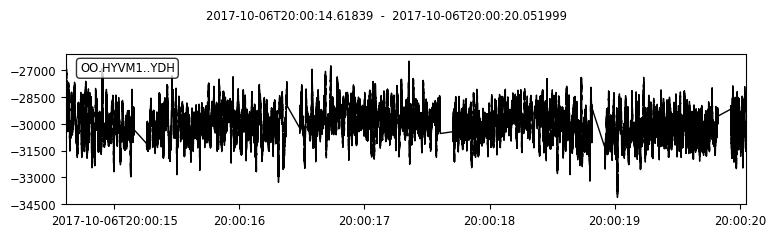

In [7]:
st_noping = stream.slice(UTCDateTime(pingtimes[14]), UTCDateTime(pingtimes[15]) - 0.05)
for i in range(5):
    st_noping = st_noping + stream.slice(UTCDateTime(pingtimes[15 + i] + 0.05), UTCDateTime(pingtimes[15 + i + 1]) - 0.05)

tr_noping = st_noping[0]
for i in range(len(st_noping)-1):
    tr_noping = tr_noping.__add__(st_noping[i + 1],fill_value = 'interpolate')
#print(tr_noping)
tr_noping.plot()


# Plot spectrogram

4096


Text(0,0.5,'Frequency [kHz]')

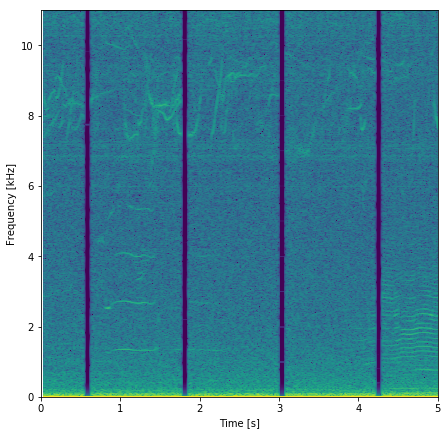

In [8]:
def _nearest_pow_2(x):

    a = M.pow(2, M.ceil(np.log2(x)))
    b = M.pow(2, M.floor(np.log2(x)))
    if abs(a - x) < abs(b - x):
        return a
    else:
        return b

wlen = 0.056;  # bin size in sec 
npts = len(st[0])
end = npts / samp_rate
nfft = int(_nearest_pow_2(wlen * samp_rate))  # number of fft points of each bin
print(nfft)
per_lap = 0.995      # percentage of overlap
nlap = int(nfft * float(per_lap))   # number of overlapped samples

# using mlab to create the array of spectrogram 
specgram, freq, time = mlab.specgram(tr_noping.data/1e-6,NFFT = nfft,Fs = samp_rate,noverlap = nlap, pad_to = None)
specgram = 10 * np.log10(specgram[1:, :])
specgram = np.flipud(specgram)
freq = freq[1:] / 1e3  # Convert Frequency to kHz
halfbin_time = (time[1] - time[0]) / 2.0
halfbin_freq = (freq[1] - freq[0]) / 2.0
freq = np.concatenate((freq, [freq[-1] + 2 * halfbin_freq]))
time = np.concatenate((time, [time[-1] + 2 * halfbin_time]))
extent = (time[0] - halfbin_time, time[-1] + halfbin_time,
                  freq[0] - halfbin_freq, freq[-1] + halfbin_freq)
# colormap setting
vmin = 0.50  # default should be 0 to start from the min number of the spectrgram
vmax = 0.95  # default should be 1 to end at the max number of the spectrgram
_range = float(specgram.max() - specgram.min())
vmin = specgram.min() + vmin * _range
vmax = specgram.min() + vmax * _range
norm = Normalize(vmin, vmax)  # to scale a 2-D float X input to the (0, 1) range for input to the cmap

# plot spectrogram
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
cax = ax.imshow(specgram, interpolation="nearest", extent=extent, norm=norm, cmap='viridis')
dpi = fig.get_dpi()
fig.set_size_inches(512/float(dpi),512/float(dpi))
ax.axis('tight')
ax.set_xlim(0, end)
ax.set_ylim(0,11)
ax.grid(False)
ax.set_xlabel('Time [s]')
ax.set_ylabel('Frequency [kHz]')
#cbar = fig.colorbar(cax)